In [171]:
import numpy as np
import pymc3 as pm
import seaborn as sns

from matplotlib import pyplot as plt
from corner import corner
from scipy.stats import norm

In [29]:
def luminosity(age):
    return 0.05 * age**2

Text(0, 0.5, 'true luminosity ($\\mathrm{L}_\\odot$)')

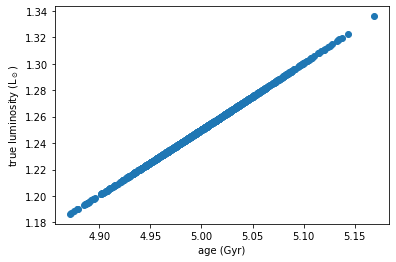

In [51]:
n_obj = 1000

mu_age_true = 5.0
sigma_age_true = 0.05
age_true = np.random.normal(mu_age_true, sigma_age_true, n_obj)
lum_true = luminosity(age_true)

plt.scatter(age_true, lum_true)
plt.xlabel('age (Gyr)')
plt.ylabel(r'true luminosity ($\mathrm{L}_\odot$)')

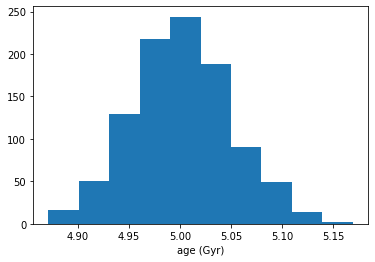

In [52]:
plt.hist(age_true)
plt.xlabel('age (Gyr)');

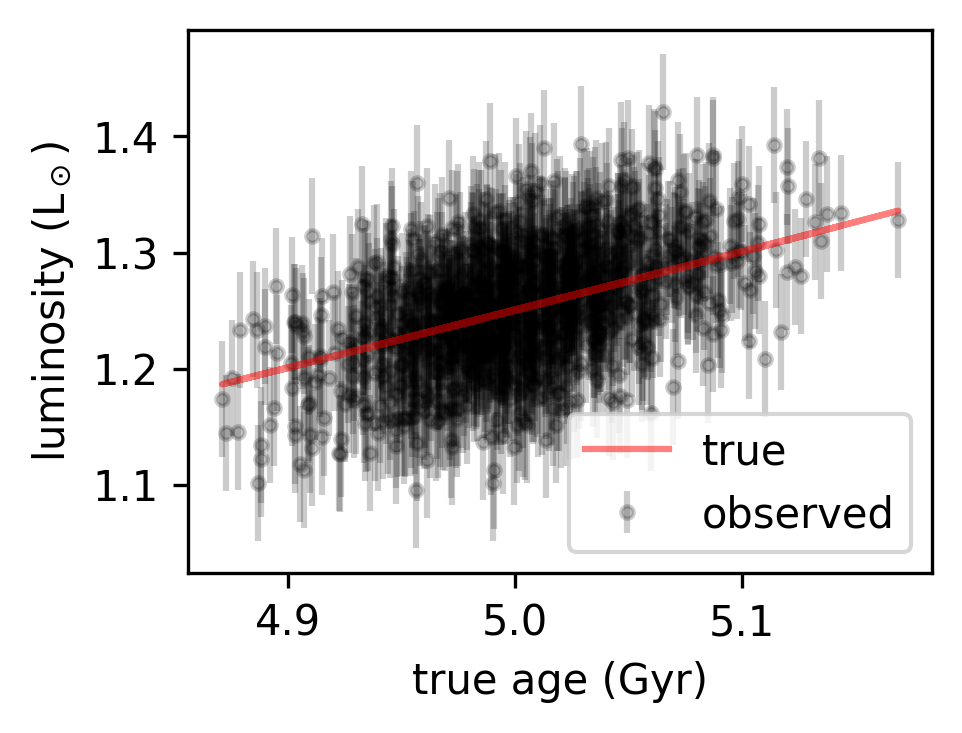

In [220]:
sigma_lum = 0.05
lum_obs = np.random.normal(lum_true, sigma_lum)

fig, ax = plt.subplots(figsize=(3.2, 2.4), dpi=300)
plt.errorbar(age_true, lum_obs, yerr=sigma_lum, fmt='k.', alpha=0.2, label='observed', zorder=0)
plt.plot(age_true, lum_true, color='r', marker='', alpha=0.5, label='true')
plt.xlabel('true age (Gyr)')
plt.ylabel(r'luminosity ($\mathrm{L}_\odot$)')
plt.legend();

fig.savefig('../introduction/images/obs_lum.png', bbox_inches='tight')

In [ ]:
space = 0.1
fig, axes = plt.subplots(2, 2, dpi=300, sharex='col', sharey='row',
                         gridspec_kw={
#                              'width_ratios': [2, 1],
                             'wspace': space, 'hspace': space
                         })

sns.distplot(ages_np, label='no pool', ax=axes[0, 0])
sns.distplot(ages_pp, label='partial pool', ax=axes[0, 0])
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('KDE')

axes[0, 1].remove()

axes[1, 0].scatter(ages_np, z_np, marker='.', alpha=0.5)
axes[1, 0].scatter(ages_pp, z_pp, marker='.', alpha=0.5)
axes[1, 0].set_xlabel('age (Gyr)')
axes[1, 0].set_ylabel('z-score')

sns.distplot(z_np, label='no pool', ax=axes[1, 1], vertical=True)
sns.distplot(z_pp, label='partial pool', ax=axes[1, 1], vertical=True)
_x = np.linspace(np.min([z_np, z_pp]), np.max([z_np, z_pp]), 500)
axes[1, 1].plot(norm.pdf(_x), _x, 'k--', label=r'$\mathcal{N}(0, 1)$', alpha=0.75)
axes[1, 1].set_xlabel('KDE')
axes[1, 1].legend(bbox_to_anchor=[.5, 1.5+space], loc='center')


In [54]:
with pm.Model() as no_pool:
    
    age = pm.Uniform('age', 0.0, 14.0, shape=n_obj)
    lum = pm.Deterministic('lum', luminosity(age))
    
    obs = pm.Normal('obs', lum, sigma_lum, observed=lum_obs)

In [55]:
with no_pool:
    np_trace = pm.sample(cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [age]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 11 seconds.


In [115]:
np_summary = pm.summary(np_trace, round_to='none')
np_summary.head()

/Users/ajl573/.virtualenvs/pymc4/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
age[0],5.044360,0.105925,4.828610,5.223112,0.002313,0.001636,2097.681492,2097.681492,2144.602732,597.257218,1.000860
age[1],5.148026,0.099980,4.962797,5.327542,0.001682,0.001189,3533.307948,3533.307948,3528.809613,1274.893296,1.000163
age[2],5.209608,0.095690,5.023419,5.380899,0.001778,0.001258,2894.959119,2894.959119,2919.728811,738.859813,1.002738
age[3],4.891642,0.099652,4.696841,5.068202,0.001606,0.001136,3851.479574,3851.479574,3830.046530,1237.778843,1.006051
age[4],4.968467,0.101559,4.757541,5.136552,0.001832,0.001295,3074.418700,3074.418700,3144.093887,1202.258062,1.000676


mu = 4.998 Gyr
sigma = 0.109 Gyr


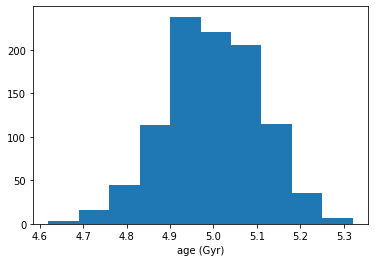

In [116]:
ages_np = np_summary.loc[[idx for idx in np_summary.index if 'age' in idx], 'mean']
mu_age_np = np.mean(ages)
sigma_age_np= np.std(ages)
print(f'mu = {mu_age_np:.3f} Gyr')
print(f'sigma = {sigma_age_np:.3f} Gyr')
plt.hist(ages_np)
plt.xlabel('age (Gyr)');

In [67]:
with pm.Model() as partial_pool:
    
    mu_age = pm.Uniform('mu_age', 0.0, 14.0)
    sigma_age = pm.Lognormal('sigma_age', np.log(0.1), 1.0)
    
    age_offset = pm.Normal('age_offset', 0.0, 1.0, shape=n_obj)
    age = pm.Deterministic('age', mu_age + sigma_age * age_offset)
    
    lum = pm.Deterministic('lum', luminosity(age))
    
    obs = pm.Normal('obs', lum, sigma_lum, observed=lum_obs)

In [68]:
with partial_pool:
    pp_trace = pm.sample(target_accept=0.95, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [age_offset, sigma_age, mu_age]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 30 seconds.


In [117]:
pp_summary = pm.summary(pp_trace, round_to='none')
pp_summary.head()

/Users/ajl573/.virtualenvs/pymc4/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
age_offset[0],0.174554,0.905836,-1.627289,1.813956,0.013921,0.024413,4234.364533,688.946772,4210.470041,1497.504122,1.002617
age_offset[1],0.529526,0.926641,-1.120212,2.244230,0.013058,0.018733,5035.628185,1223.997589,5170.078690,1357.482810,1.001263
age_offset[2],0.762188,0.906631,-0.962320,2.394231,0.012953,0.018366,4898.979470,1218.960455,4809.515782,1363.898900,1.002138
age_offset[3],-0.349049,0.898726,-1.956108,1.477228,0.011930,0.019996,5675.475374,1010.650742,5779.362707,1521.640645,1.002585
age_offset[4],-0.121546,0.912389,-1.783114,1.641560,0.013093,0.023081,4855.870693,781.909419,4863.020928,1460.639709,1.001974


In [212]:
print(pp_summary.loc['mu_age', 'sd'])
print(pp_summary.loc['sigma_age', 'sd'])

0.0034886078268137086
0.006616432551183452


mu = 5.002 Gyr
sigma = 0.042 Gyr


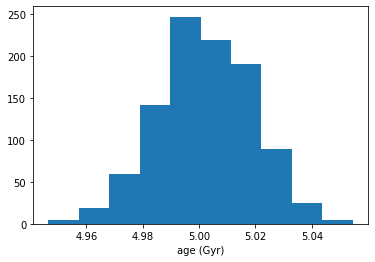

In [118]:
ages_pp = pp_summary.loc[[idx for idx in pp_summary.index if 'age[' in idx], 'mean']
mu_age_pp = pp_summary.loc['mu_age', 'mean']
sigma_age_pp= pp_summary.loc['sigma_age', 'mean']
print(f'mu = {mu_age_pp:.3f} Gyr')
print(f'sigma = {sigma_age_pp:.3f} Gyr')
plt.hist(ages_pp)
plt.xlabel('age (Gyr)');

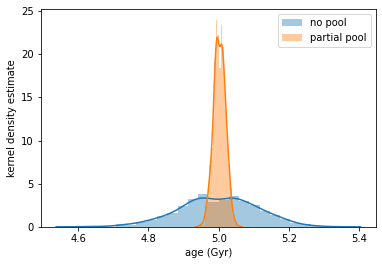

In [119]:
sns.distplot(ages_np, label='no pool')
sns.distplot(ages_pp, label='partial pool')
plt.xlabel('age (Gyr)')
plt.ylabel('kernel density estimate')
plt.legend();

In [120]:
labels = ['mu_age', 'sigma_age']
xs = np.array([pp_trace[label] for label in labels]).T

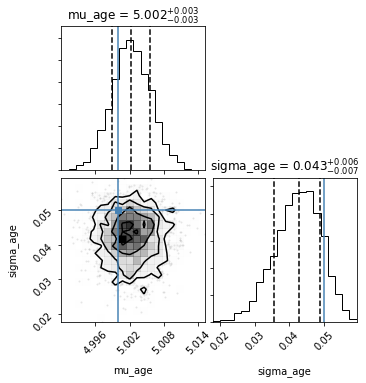

In [121]:
fig = corner(xs, labels=labels, truths=[mu_age_true, sigma_age_true],
             show_titles=True, title_fmt='.3f', quantiles=[.16, .5, .84])

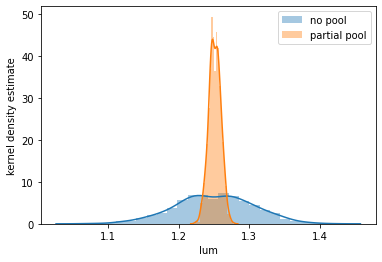

In [122]:
lums_np = np_summary.loc[[idx for idx in np_summary.index if 'lum[' in idx], 'mean']
lums_pp = pp_summary.loc[[idx for idx in pp_summary.index if 'lum[' in idx], 'mean']
sns.distplot(lums_np, label='no pool')
sns.distplot(lums_pp, label='partial pool')
plt.xlabel('lum')
plt.ylabel('kernel density estimate')
plt.legend();

In [123]:
age_sd_np = np_summary.loc[[idx for idx in np_summary.index if 'age[' in idx], 'sd']
age_sd_pp = pp_summary.loc[[idx for idx in pp_summary.index if 'age[' in idx], 'sd']

In [124]:
z_np = (ages_np - age_true) / age_sd_np
z_pp = (ages_pp - age_true) / age_sd_pp

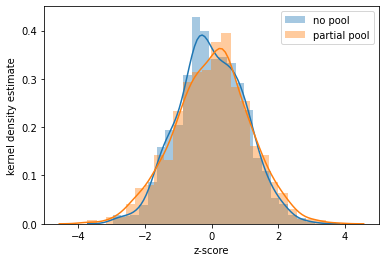

In [129]:
sns.distplot(z_np, label='no pool')
sns.distplot(z_pp, label='partial pool')
plt.xlabel('z-score')
plt.ylabel('kernel density estimate')
plt.legend();

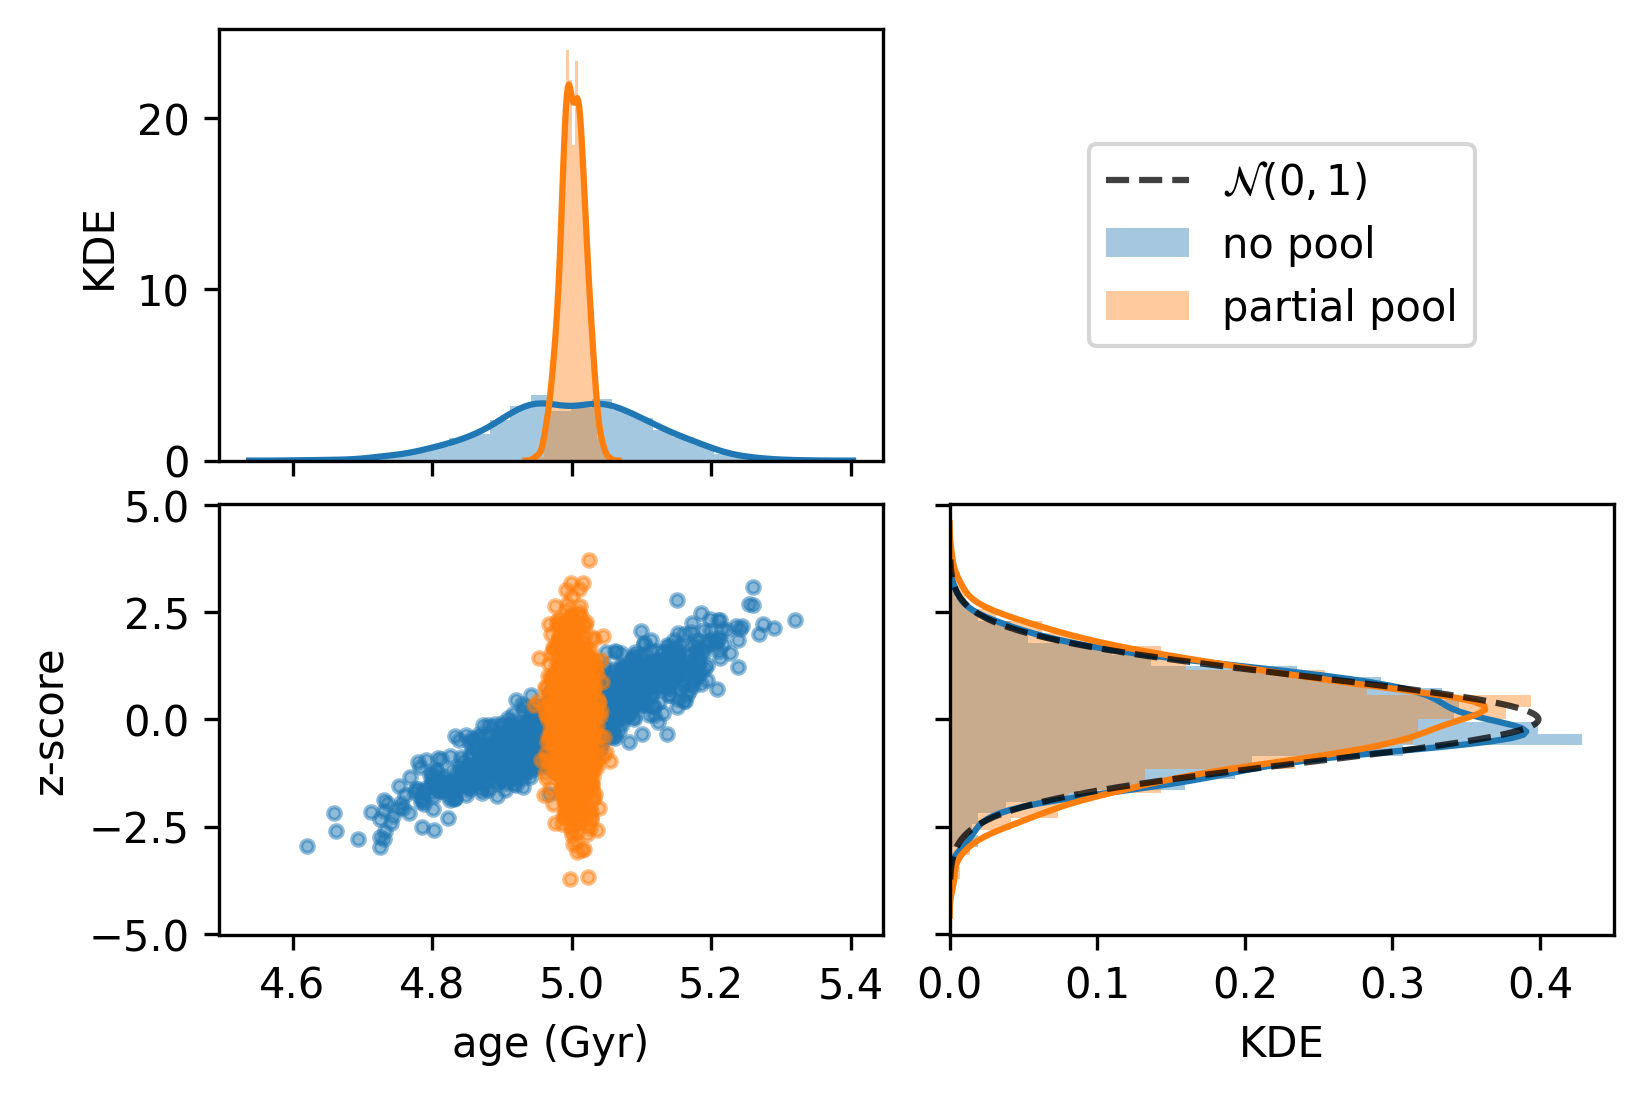

In [196]:
space = 0.1
fig, axes = plt.subplots(2, 2, dpi=300, sharex='col', sharey='row',
                         gridspec_kw={
#                              'width_ratios': [2, 1],
                             'wspace': space, 'hspace': space
                         })

sns.distplot(ages_np, label='no pool', ax=axes[0, 0])
sns.distplot(ages_pp, label='partial pool', ax=axes[0, 0])
axes[0, 0].set_xlabel('')
axes[0, 0].set_ylabel('KDE')

axes[0, 1].remove()

axes[1, 0].scatter(ages_np, z_np, marker='.', alpha=0.5)
axes[1, 0].scatter(ages_pp, z_pp, marker='.', alpha=0.5)
axes[1, 0].set_xlabel('age (Gyr)')
axes[1, 0].set_ylabel('z-score')

sns.distplot(z_np, label='no pool', ax=axes[1, 1], vertical=True)
sns.distplot(z_pp, label='partial pool', ax=axes[1, 1], vertical=True)
_x = np.linspace(np.min([z_np, z_pp]), np.max([z_np, z_pp]), 500)
axes[1, 1].plot(norm.pdf(_x), _x, 'k--', label=r'$\mathcal{N}(0, 1)$', alpha=0.75)
axes[1, 1].set_xlabel('KDE')
axes[1, 1].legend(bbox_to_anchor=[.5, 1.5+space], loc='center')

fig.savefig('../introduction/images/age_z_score.png', bbox_inches='tight')

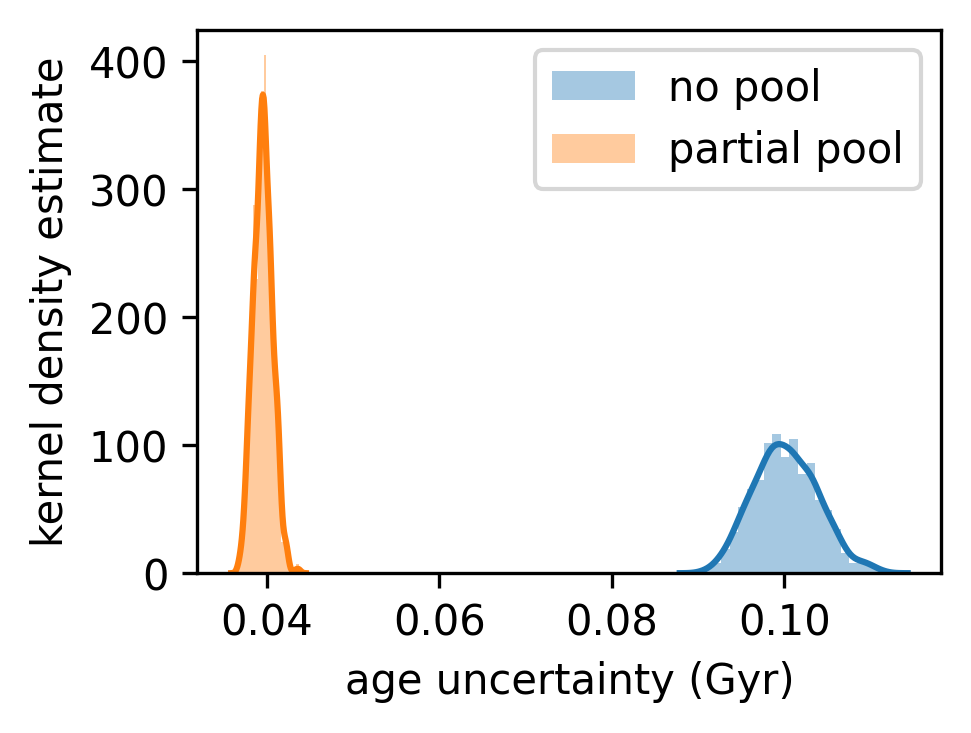

In [197]:
fig, ax = plt.subplots(figsize=(3.2, 2.4), dpi=300)
sns.distplot(age_sd_np, label='no pool')
sns.distplot(age_sd_pp, label='partial pool')
plt.xlabel('age uncertainty (Gyr)')
plt.ylabel('kernel density estimate')
plt.legend()

fig.savefig('../introduction/images/age_uncertainties.png', bbox_inches='tight')